In [30]:
! pip install kneed

In [ ]:
! pip install tslearn

In [ ]:

import math
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
from functools import reduce
from scipy import stats
from kneed import KneeLocator
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

from typing import List



from tslearn.barycenters import dtw_barycenter_averaging
from tslearn.clustering import TimeSeriesKMeans

### Подготовка данных
- определяем временные отрезки для проведения кластеризации данных и непосредственно теста

In [2]:
path = r"C:\Users\repin\Desktop\GitHub\TestLab\development\test-data.csv"
df = pd.read_csv(path)

In [3]:
# добавим данные по месяцу и дате в удобном формате
df['month'] = df['Date'].apply(lambda x: x[:7])
df['dt'] = df['Date'].apply(lambda x: x[:10])

In [4]:
# введем переменные с датами
# пусть предэкспериментальный период будет равен 50 дням (чуть больше теста)
end_of_30 = datetime.datetime.strptime('2022-04-07', "%Y-%m-%d")
start_of_30 = end_of_30 + datetime.timedelta(days=-50)

start_dt = start_of_30.strftime("%Y-%m-%d")
end_dt = end_of_30.strftime("%Y-%m-%d")
end_of_test_dt = '2022-05-19'
start_dt, end_dt, end_of_test_dt

('2022-02-16', '2022-04-07', '2022-05-19')

In [5]:
# данные экспериментального периода
experiment = df[
    (df['dt'] > end_dt)&(df['dt'] <= end_of_test_dt)
    &(df['OrderSource'] == 'web')&(df['Category'] == 'пицца')
    ]
experiment.shape

(11042, 14)

In [6]:
# данные предэкспериментального периода
pre_exp = df[
    (df['dt'] >= start_dt)&(df['dt'] < end_dt)
    &(df['OrderSource'] == 'web')&(df['Category'] == 'пицца')
    ]
pre_exp.shape

(13140, 14)

In [7]:
pre_exp[pre_exp["CityName"]=="Казань"].head(3)

,Date,CityName,OrderSource,Category,rto,rto_do,cost,qty,tickets,clients_qty,avg_time,avg_price,month,dt
140171,2022-02-16T00:00:00.000Z,Казань,web,пицца,100899.4931,113463.81,24328.389720,232.0,130.0,124.0,29.087296,434.911608,2022-02,2022-02-16
143192,2022-02-17T00:00:00.000Z,Казань,web,пицца,110966.3100,126714.60,28893.071037,255.0,140.0,134.0,12.555224,435.162000,2022-02,2022-02-17
146230,2022-02-18T00:00:00.000Z,Казань,web,пицца,155305.9480,182940.36,39929.625037,371.0,202.0,193.0,25.779657,418.614415,2022-02,2022-02-18


In [8]:
assert pre_exp['CityName'].nunique() == df['CityName'].nunique() # нет новых городов на предэкспериментальном периоде

In [9]:
assert pre_exp['CityName'].nunique() == experiment['CityName'].nunique() # нет новых городов на экспериментальном периоде

In [10]:
pre_exp[pre_exp["CityName"]=="Самара"].shape

(50, 14)

### Сравнение методов кластеризации данных
- KMeans агрегированных данных
- KMeans временных рядов
- KNN (на всех данных)
- векторное сравнение

#### Кластеризация агрегированных данных

In [528]:
# соберем датасет для кластеризации
pivot_for_cluster = pre_exp.groupby('CityName').agg(
    {
        'rto': 'sum',
        'cost': 'sum',
        'qty': 'sum',
        'clients_qty': 'sum'
    }
).sort_values('rto', ascending=False).reset_index()
pivot_for_cluster['rto'] = pivot_for_cluster['rto'].astype('int')
pivot_for_cluster['cost'] = pivot_for_cluster['cost'].astype('int')
# уберем из кластеризации Москву и Спб, так как кластеризация выделяет их в отдельный кластер, мы этого не хотим.
pivot_for_cluster = pivot_for_cluster[~pivot_for_cluster['CityName'].isin(['Москва', 'Санкт-Петербург'])].reset_index(drop=True)
pivot_for_cluster.head(10)

,CityName,rto,cost,qty,clients_qty
0,Самара,16026737,4050406,34875.0,17166.0
1,Екатеринбург,13663217,3337150,29147.0,14582.0
2,Челябинск,10433277,2794639,23451.0,12220.0
3,Краснодар,8609991,2047640,16589.0,8872.0
4,Нижний Новгород,8479303,2120621,17312.0,8927.0
5,Ульяновск,8051164,2109697,19359.0,9450.0
6,Новосибирск,7755947,1989265,15631.0,7355.0
7,Тюмень,7740492,1849008,15715.0,8240.0
8,Ростов-на-Дону,7499478,1955061,16254.0,7378.0
9,Казань,6658360,1735571,14797.0,7471.0


Проведем кластеризацию городов на предэкспериментальном периоде

In [530]:
scaled_df = StandardScaler().fit_transform(pivot_for_cluster[['rto', 'cost', 'qty', 'clients_qty']])

In [20]:
print(scaled_df[:5])

[[7.16860849 7.08454191 7.29296118 7.09628649]
 [5.99473992 5.69576411 5.96858447 5.90551881]
 [4.39055419 4.6394432  4.65160651 4.81705392]
 [3.48499887 3.18496455 3.06503651 3.27421715]
 [3.42009121 3.32706555 3.23220207 3.29956244]]


In [531]:
kmeans_kwargs = {
  "init": "random",
  "n_init": 20,
  "random_state": 42,
}

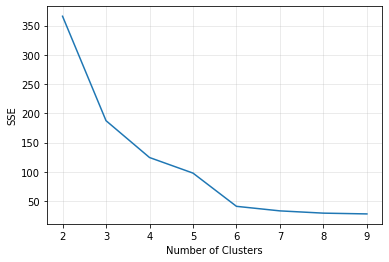

In [532]:
# определяем оптимальное кол-во кластеров
sse = []
start_clusters_nums = 2
end_clusters_nums = 10
for k in range(start_clusters_nums, end_clusters_nums):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_df)
    sse.append(kmeans.inertia_)
plt.plot(range(start_clusters_nums, end_clusters_nums), sse)
plt.xticks(range(start_clusters_nums, end_clusters_nums))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.grid(alpha=0.3)
plt.show()

крутой излом начинается с 6-го кластера, проверим с помощью встроенного метода

In [541]:
kl = KneeLocator(
    range(start_clusters_nums, end_clusters_nums), sse, curve="convex", direction="decreasing"
)
kl.elbow

6

In [542]:
# также можно проверить итератирвно с помощью silhouette_score
silhouette_coefficients = []

for k in range(start_clusters_nums, end_clusters_nums):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(scaled_df)
    score = silhouette_score(scaled_df, kmeans.labels_)
    silhouette_coefficients.append(score)

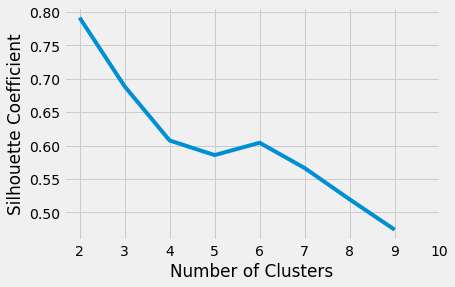

In [543]:
plt.style.use("fivethirtyeight")
plt.plot(range(start_clusters_nums, end_clusters_nums), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

Вывод: 6 кластеров - оптимальное значение для выбранных данных

In [544]:
kmeans = KMeans(init="random", n_clusters=kl.elbow, n_init=10, random_state=42)
kmeans.fit(scaled_df)
kmeans.labels_[:5]

array([4, 4, 4, 4, 4])

In [545]:
pivot_for_cluster['cluster'] = kmeans.labels_

In [546]:
pivot_for_cluster['cluster'].value_counts()

0    109
3     63
1     42
2     24
5     15
4      9
Name: cluster, dtype: int64

In [547]:
# посмотрим какие кластера получились
pd.options.display.max_colwidth = 1000
pivot_for_cluster.groupby(['cluster']).agg({'CityName': lambda x: list(x)})

,CityName
cluster,
0,"[Апатиты, Воркута, Сергиев Посад, Красное Село, Солнечногорск, Звенигород, Верхняя Пышма, Выборг, Кингисепп, Нахабино, Наро-Фоминск, Нижнекамск, Егорьевск, Усинск, Шушары, Кириши, Анапа, Орск, Горно-Алтайск, Лыткарино, Ступино, Старая Купавна, Нягань, Салават, Можайск, Югорск, Ленинск-Кузнецкий, Стерлитамак, Ковров, Златоуст, Внуково, Копейск, Аксай Россия, Шатура, Александров, Прокопьевск, Геленджик, Чайковский, Рыбинск, Павловский Посад, Новочебоксарск, Кубинка, Октябрьский, Кронштадт, Шлиссельбург, Губкинский, Муром, Кстово, Ликино-Дулево, Батайск, Невинномысск, Махачкала, Пятигорск, Камышин, Муравленко, Металлострой, Тосно, Усолье-Сибирское, Владикавказ, Сызрань, Вязьма, Электроугли, Азов, Канск, Новоуральск, Майкоп, Стрежевой, Ессентуки, Губкин, Бугульма, Лянтор, Воткинск, Хотьково, Урай, Корсаков, Лабытнанги, Голицыно, Каменск-Шахтинский, Волхов, Сарапул, Заречный, Ржев, Котлас, Краснокамск, Полевской, Конаково, Грозный, Белогорск, Абинск, Минеральные Воды, Переславль-Залесск..."
1,"[Красногорск, Балашиха, Люберцы, Сочи, Долгопрудный, Мурманск, Магадан, Одинцово, Курган, Реутов, Череповец, Щелково, Тамбов, Нефтеюганск, Белгород, Псков, Астрахань, Петергоф, Таганрог, Домодедово, Мурино, Всеволожск, Брянск, Бердск, Нижний Тагил, Железнодорожный, Парголово, Барнаул, Вологда, Магнитогорск, Тула, Коммунарка, Архангельск, Ухта, Братск, Ханты-Мансийск, Великий Новгород, Курск, Саранск, Кемерово, Новокузнецк, Орел]"
2,"[Иркутск, Нижневартовск, Хабаровск, Красноярск, Калининград, Мытищи, Смоленск, Южно-Сахалинск, Пенза, Новый Уренгой, Благовещенск, Королев, Чита, Химки, Рязань, Щербинка, Якутск, Новороссийск, Ставрополь, Зеленоград, Владивосток, Чебоксары, Петрозаводск, Комсомольск-на-Амуре]"
3,"[Норильск, Салехард, Ноябрьск, Надым, Дубна, Ногинск, Йошкар-Ола, Лобня, Березники, Обнинск, Серпухов, Подольск, Колпино, Пушкино, Троицк, Липецк, Рассказовка, Волжский, Орехово-Зуево, Абакан, Калуга, Кудрово, Набережные Челны, Гатчина, Московский, Северск, Дмитров, Фрязино, Северодвинск, Дзержинск, Иваново, Уссурийск, Видное, Электросталь, Балаково, Тобольск, Петропавловск-Камчатский, Коломна, Сертолово, Владимир, Клин, Энгельс, Ивантеевка, Пушкин, Сосновый Бор, Славянка, Улан-Удэ, Чехов, Жуковский, Воскресенск, Дедовск, Альметьевск, Когалым, Раменское, Апрелевка, Каменск-Уральский, Находка, Истра, Саров, Новокуйбышевск, Никольское, Миасс, Старый Оскол]"
4,"[Самара, Екатеринбург, Челябинск, Краснодар, Нижний Новгород, Ульяновск, Новосибирск, Тюмень, Ростов-на-Дону]"
5,"[Казань, Саратов, Воронеж, Тольятти, Омск, Сургут, Уфа, Томск, Оренбург, Киров, Тверь, Волгоград, Сыктывкар, Пермь, Ижевск]"


In [31]:
test_towns = ['Пенза', 'Уфа', 'Курск', 'Нижний Тагил', 'Новокуйбышевск', 'Орск']

In [549]:
pivot_for_cluster[pivot_for_cluster['CityName'].isin(test_towns)]

,CityName,rto,cost,qty,clients_qty,cluster
15,Уфа,4831874,1310332,11202.0,5689.0,5
32,Пенза,3164901,884061,7114.0,3790.0,2
72,Нижний Тагил,1655917,461095,3914.0,2176.0,1
89,Курск,1451251,382650,2992.0,1876.0,1
151,Новокуйбышевск,749163,200506,1795.0,982.0,3
170,Орск,633995,175330,1338.0,765.0,0


Чтобы посмотреть не только кластер города, но и найти окрестность соседних городов, посчитаем дисперсию метрики для каждого города в рамках его кластера и отсортируем по ее убыванию

In [550]:
# считаем стандартное отклонение для каждого города
total_revenue = pre_exp.groupby(['CityName', 'dt']).agg({'rto': 'sum'}).reset_index()
pivot_disp = total_revenue.groupby('CityName').agg({'rto': 'std'}).sort_values('rto', ascending=False).reset_index()
pivot_disp['rto'] = pivot_disp['rto'].astype('int')
pivot_disp.rename(columns={'rto': 'rto_std'}, inplace=True)
pivot_disp.head(2)

,CityName,rto_std
0,Москва,792806
1,Санкт-Петербург,372616


In [551]:
pivot = pivot_for_cluster.merge(pivot_disp, how='left', on=['CityName'])
pivot.head()

,CityName,rto,cost,qty,clients_qty,cluster,rto_std
0,Самара,16026737,4050406,34875.0,17166.0,4,172555
1,Екатеринбург,13663217,3337150,29147.0,14582.0,4,125546
2,Челябинск,10433277,2794639,23451.0,12220.0,4,92818
3,Краснодар,8609991,2047640,16589.0,8872.0,4,69393
4,Нижний Новгород,8479303,2120621,17312.0,8927.0,4,79321


Отбор в группы

In [552]:
def foo(diff_with_down, diff_with_up, dif):
  if diff_with_down > diff_with_up:
    return dif
  else:
    return -dif

In [553]:
# сдвигаем наблюдения и рассчитываем разницу между значениями верхнего соседа и нижнего
pivot = pivot.sort_values(['cluster', 'rto_std']).reset_index(drop=True)
pivot['down_shift_1'] = pivot['rto_std'].shift(1, fill_value=0)
pivot['up_shift_1'] = pivot['rto_std'].shift(-1, fill_value=0)
pivot['down_shift_2'] = pivot['rto_std'].shift(2, fill_value=0)
pivot['up_shift_2'] = pivot['rto_std'].shift(-2, fill_value=0)
pivot['diff_with_down_1'] = abs(pivot['rto_std'] - pivot['down_shift_1'])
pivot['diff_with_up_1'] = abs(pivot['rto_std'] - pivot['up_shift_1'])
pivot['diff_with_down_2'] = abs(pivot['rto_std'] - pivot['down_shift_2'])
pivot['diff_with_up_2'] = abs(pivot['rto_std'] - pivot['up_shift_2'])


pivot['neighbour_1'] = pivot.apply(lambda x: foo(x['diff_with_down_1'], x['diff_with_up_1'], 1), axis=1)
pivot['neighbour_2'] = pivot.apply(lambda x: foo(x['diff_with_down_2'], x['diff_with_up_2'], 2), axis=1)
pivot['neighbour_index_1'] = pivot.index + pivot['neighbour_1']
pivot['neighbour_index_2'] = pivot.index + pivot['neighbour_2']

In [559]:
test_ids = set(pivot[pivot["CityName"].isin(test_towns)].index)
test_ids

{96, 112, 128, 166, 177, 251}

In [618]:
result_ids

{'Пенза': ['Пенза', 'Рязань', 'Смоленск', 'Чита', 'Южно-Сахалинск'],
 'Уфа': ['Уфа', 'Оренбург', 'Киров', 'Томск', 'Омск'],
 'Курск': ['Курск', 'Ухта', 'Саранск', 'Колпино', 'Братск'],
 'Нижний Тагил': ['Нижний Тагил', 'Брянск', 'Ухта', 'Коммунарка', 'Ноябрьск'],
 'Новокуйбышевск': ['Новокуйбышевск',
  'Выборг',
  'Саров',
  'Альметьевск',
  'Старый Оскол'],
 'Орск': ['Орск', 'Ковров', 'Копейск', 'Верхняя Пышма', 'Ступино']}

In [613]:
for i in test_ids:
    display(pivot.iloc[i, 0])
    display(pivot.iloc[i-15:i+15, :])

'Орск'

,CityName,rto,cost,qty,clients_qty,cluster,rto_std,down_shift_1,up_shift_1,down_shift_2,up_shift_2,diff_with_down_1,diff_with_up_1,diff_with_down_2,diff_with_up_2,neighbour_1,neighbour_2,neighbour_index_1,neighbour_index_2
81,Ковров,530011,152754,1158.0,713.0,0,6573,6509,6602,6403,6617,64,29,170,44,1,2,82,83
82,Можайск,558078,143853,1140.0,648.0,0,6602,6573,6617,6509,6630,29,15,93,28,1,2,83,84
83,Кронштадт,469329,118929,949.0,492.0,0,6617,6602,6630,6573,6702,15,13,44,85,1,-2,84,81
84,Усинск,646352,131520,1213.0,751.0,0,6630,6617,6702,6602,6738,13,72,28,108,-1,-2,83,82
85,Кингисепп,714840,189037,1477.0,820.0,0,6702,6630,6738,6617,6971,72,36,85,269,1,-2,86,83
86,Наро-Фоминск,684839,167321,1315.0,742.0,0,6738,6702,6971,6630,6984,36,233,108,246,-1,-2,85,84
87,Нахабино,688646,173936,1352.0,707.0,0,6971,6738,6984,6702,7077,233,13,269,106,1,2,88,89
88,Выборг,716922,177073,1410.0,849.0,0,6984,6971,7077,6738,7117,13,93,246,133,-1,2,87,90
89,Югорск,551322,137719,1150.0,666.0,0,7077,6984,7117,6971,7260,93,40,106,183,1,-2,90,87
90,Нягань,568232,127374,1113.0,621.0,0,7117,7077,7260,6984,7308,40,143,133,191,-1,-2,89,88


'Нижний Тагил'

,CityName,rto,cost,qty,clients_qty,cluster,rto_std,down_shift_1,up_shift_1,down_shift_2,up_shift_2,diff_with_down_1,diff_with_up_1,diff_with_down_2,diff_with_up_2,neighbour_1,neighbour_2,neighbour_index_1,neighbour_index_2
113,Ханты-Мансийск,1464048,361440,2829.0,1685.0,1,14293,14154,14613,13154,14666,139,320,1139,373,-1,2,112,115
114,Архангельск,1525949,396567,3122.0,1828.0,1,14613,14293,14666,14154,14848,320,53,459,235,1,2,115,116
115,Орел,1409548,413836,3173.0,1864.0,1,14666,14613,14848,14293,15121,53,182,373,455,-1,-2,114,113
116,Саранск,1444989,423437,3203.0,1955.0,1,14848,14666,15121,14613,15312,182,273,235,464,-1,-2,115,114
117,Астрахань,1793629,466227,3832.0,2140.0,1,15121,14848,15312,14666,15412,273,191,455,291,1,2,118,119
118,Парголово,1617819,418283,3447.0,1793.0,1,15312,15121,15412,14848,15540,191,100,464,228,1,2,119,120
119,Магнитогорск,1546936,415023,3246.0,1765.0,1,15412,15312,15540,15121,15868,100,128,291,456,-1,-2,118,117
120,Коммунарка,1530273,376998,2969.0,1606.0,1,15540,15412,15868,15312,16067,128,328,228,527,-1,-2,119,118
121,Брянск,1710260,486276,3629.0,2106.0,1,15868,15540,16067,15412,16400,328,199,456,532,1,-2,122,119
122,Ухта,1491364,353680,2895.0,1743.0,1,16067,15868,16400,15540,16486,199,333,527,419,-1,2,121,124


'Пенза'

,CityName,rto,cost,qty,clients_qty,cluster,rto_std,down_shift_1,up_shift_1,down_shift_2,up_shift_2,diff_with_down_1,diff_with_up_1,diff_with_down_2,diff_with_up_2,neighbour_1,neighbour_2,neighbour_index_1,neighbour_index_2
151,Новороссийск,2447644,628950,4824.0,2737.0,2,18827,25162,19224,22993,21896,6335,397,4166,3069,1,2,152,153
152,Якутск,2574504,545177,4650.0,2664.0,2,19224,18827,21896,25162,21932,397,2672,5938,2708,-1,2,151,154
153,Ставрополь,2411540,676592,5151.0,2767.0,2,21896,19224,21932,18827,22046,2672,36,3069,150,1,2,154,155
154,Зеленоград,2393014,634864,4833.0,2454.0,2,21932,21896,22046,19224,22634,36,114,2708,702,-1,2,153,156
155,Комсомольск-на-Амуре,2212126,604389,4792.0,2703.0,2,22046,21932,22634,21896,22787,114,588,150,741,-1,-2,154,153
156,Петрозаводск,2291052,616833,4863.0,2878.0,2,22634,22046,22787,21932,25626,588,153,702,2992,1,-2,157,154
157,Владивосток,2356751,634602,4862.0,2352.0,2,22787,22634,25626,22046,26224,153,2839,741,3437,-1,-2,156,155
158,Благовещенск,3015375,819214,5654.0,3252.0,2,25626,22787,26224,22634,26383,2839,598,2992,757,1,2,159,160
159,Химки,2884041,746234,5703.0,2704.0,2,26224,25626,26383,22787,28483,598,159,3437,2259,1,2,160,161
160,Чебоксары,2292495,566379,4974.0,2698.0,2,26383,26224,28483,25626,28655,159,2100,757,2272,-1,-2,159,158


'Курск'

,CityName,rto,cost,qty,clients_qty,cluster,rto_std,down_shift_1,up_shift_1,down_shift_2,up_shift_2,diff_with_down_1,diff_with_up_1,diff_with_down_2,diff_with_up_2,neighbour_1,neighbour_2,neighbour_index_1,neighbour_index_2
97,Красное Село,739189,187966,1581.0,745.0,0,7585,7526,7722,7441,7819,59,137,144,234,-1,-2,96,95
98,Сергиев Посад,740455,176198,1398.0,871.0,0,7722,7585,7819,7526,7855,137,97,196,133,1,2,99,100
99,Аксай Россия,504374,139709,1036.0,574.0,0,7819,7722,7855,7585,7877,97,36,234,58,1,2,100,101
100,Рыбинск,480334,139309,1064.0,621.0,0,7855,7819,7877,7722,7884,36,22,133,29,1,2,101,102
101,Шушары,644352,165929,1350.0,741.0,0,7877,7855,7884,7819,8017,22,7,58,140,1,-2,102,99
102,Апатиты,810166,187151,1423.0,821.0,0,7884,7877,8017,7855,8365,7,133,29,481,-1,-2,101,100
103,Егорьевск,659823,170175,1292.0,745.0,0,8017,7884,8365,7877,8458,133,348,140,441,-1,-2,102,101
104,Старая Купавна,574662,148184,1150.0,604.0,0,8365,8017,8458,7884,8465,348,93,481,100,1,2,105,106
105,Воркута,783691,152831,1481.0,803.0,0,8458,8365,8465,8017,8965,93,7,441,507,1,-2,106,103
106,Лыткарино,618685,153719,1181.0,667.0,0,8465,8458,8965,8365,11016,7,500,100,2551,-1,-2,105,104


'Новокуйбышевск'

,CityName,rto,cost,qty,clients_qty,cluster,rto_std,down_shift_1,up_shift_1,down_shift_2,up_shift_2,diff_with_down_1,diff_with_up_1,diff_with_down_2,diff_with_up_2,neighbour_1,neighbour_2,neighbour_index_1,neighbour_index_2
162,Смоленск,3197983,923385,6781.0,4032.0,2,28655,28483,29464,26383,29589,172,809,2272,934,-1,2,161,164
163,Южно-Сахалинск,3184324,689624,5079.0,2917.0,2,29464,28655,29589,28483,29732,809,125,981,268,1,2,164,165
164,Рязань,2856337,826338,6032.0,3412.0,2,29589,29464,29732,28655,31834,125,143,934,2245,-1,-2,163,162
165,Новый Уренгой,3050173,831581,5102.0,2863.0,2,29732,29589,31834,29464,32555,143,2102,268,2823,-1,-2,164,163
166,Пенза,3164901,884061,7114.0,3790.0,2,31834,29732,32555,29589,33602,2102,721,2245,1768,1,2,167,168
167,Королев,2983282,735835,5668.0,2930.0,2,32555,31834,33602,29732,34892,721,1047,2823,2337,-1,2,166,169
168,Мытищи,3265289,821919,6366.0,3189.0,2,33602,32555,34892,31834,35103,1047,1290,1768,1501,-1,2,167,170
169,Иркутск,3698891,929802,7612.0,4176.0,2,34892,33602,35103,32555,35706,1290,211,2337,814,1,2,170,171
170,Нижневартовск,3658561,888569,7387.0,3746.0,2,35103,34892,35706,33602,35787,211,603,1501,684,-1,2,169,172
171,Калининград,3384726,759988,6513.0,3432.0,2,35706,35103,35787,34892,41355,603,81,814,5649,1,-2,172,169


'Уфа'

,CityName,rto,cost,qty,clients_qty,cluster,rto_std,down_shift_1,up_shift_1,down_shift_2,up_shift_2,diff_with_down_1,diff_with_up_1,diff_with_down_2,diff_with_up_2,neighbour_1,neighbour_2,neighbour_index_1,neighbour_index_2
236,Ноябрьск,1485886,322129,2699.0,1439.0,3,17068,16549,17126,16218,61272,519,58,850,44204,1,-2,237,234
237,Ногинск,1355563,360560,2675.0,1303.0,3,17126,17068,61272,16549,67937,58,44146,577,50811,-1,-2,236,235
238,Ростов-на-Дону,7499478,1955061,16254.0,7378.0,4,61272,17126,67937,17068,69393,44146,6665,44204,8121,1,2,239,240
239,Тюмень,7740492,1849008,15715.0,8240.0,4,67937,61272,69393,17126,79321,6665,1456,50811,11384,1,2,240,241
240,Краснодар,8609991,2047640,16589.0,8872.0,4,69393,67937,79321,61272,79486,1456,9928,8121,10093,-1,-2,239,238
241,Нижний Новгород,8479303,2120621,17312.0,8927.0,4,79321,69393,79486,67937,92818,9928,165,11384,13497,1,-2,242,239
242,Ульяновск,8051164,2109697,19359.0,9450.0,4,79486,79321,92818,69393,116479,165,13332,10093,36993,-1,-2,241,240
243,Челябинск,10433277,2794639,23451.0,12220.0,4,92818,79486,116479,79321,125546,13332,23661,13497,32728,-1,-2,242,241
244,Новосибирск,7755947,1989265,15631.0,7355.0,4,116479,92818,125546,79486,172555,23661,9067,36993,56076,1,-2,245,242
245,Екатеринбург,13663217,3337150,29147.0,14582.0,4,125546,116479,172555,92818,34884,9067,47009,32728,90662,-1,-2,244,243


#### Кластеризация временных рядов

##### tslearn

In [50]:
pre_exp.head()

,Date,CityName,OrderSource,Category,rto,rto_do,cost,qty,tickets,clients_qty,avg_time,avg_price,month,dt
139295,2022-02-16T00:00:00.000Z,Абакан,web,пицца,19586.21,21464.73,5098.530568,40.0,19.0,18.0,35.345056,489.655250,2022-02,2022-02-16
139307,2022-02-16T00:00:00.000Z,Абинск,web,пицца,7909.93,8600.16,2051.308277,18.0,10.0,10.0,30.992893,439.440556,2022-02,2022-02-16
139319,2022-02-16T00:00:00.000Z,Азов,web,пицца,2019.43,2210.31,550.452191,4.0,2.0,2.0,32.554409,504.857500,2022-02,2022-02-16
139329,2022-02-16T00:00:00.000Z,Аксай Россия,web,пицца,2657.27,2746.59,572.321473,7.0,5.0,5.0,23.590850,379.610000,2022-02,2022-02-16
139340,2022-02-16T00:00:00.000Z,Александров,web,пицца,7047.18,8009.76,1653.638279,19.0,9.0,8.0,35.216210,370.904211,2022-02,2022-02-16


In [49]:
city_names = set(pre_exp["CityName"])
len(city_names)

264

In [69]:
metric_name = "rto"

series_data = []
for city in city_names:
    t = pre_exp[pre_exp["CityName"]==city][["dt", metric_name]]
    t.set_index("dt",inplace=True)
    t.sort_index(inplace=True)
    series_data.append(t[:42])

In [70]:
len(series_data), set([len(i) for i in series_data])

(264, {42})

In [72]:
for i in range(len(series_data)):
    scaler = MinMaxScaler()
    series_data[i] = MinMaxScaler().fit_transform(series_data[i])
    series_data[i]= series_data[i].reshape(len(series_data[i]))

In [85]:
for i in range(len(series_data)):
    series_data[i]= series_data[i].reshape(-1, 1)

In [73]:
print("max: "+str(max(series_data[0]))+"\tmin: "+str(min(series_data[0])))
print(series_data[0][:5])

max: 1.0	min: 0.0
[0.26835197 0.46240101 0.64574153 0.6026459  0.48489953]


In [ ]:
from tslearn.generators import random_walks
X = random_walks(n_ts=50, sz=32, d=1)
X[0]

In [ ]:
np.array(series_data)

In [ ]:
X_train

In [ ]:
cluster_count = 10

km = TimeSeriesKMeans(n_clusters=cluster_count, metric="dtw")

labels = km.fit_predict(np.array(X_train))

In [ ]:
plot_count = math.ceil(math.sqrt(cluster_count))

fig, axs = plt.subplots(plot_count,plot_count,figsize=(25,25))
fig.suptitle('Clusters')
row_i=0
column_j=0
# For each label there is,
# plots every series with that label
for label in set(labels):
    cluster = []
    for i in range(len(labels)):
            if(labels[i]==label):
                axs[row_i, column_j].plot(mySeries[i],c="gray",alpha=0.4)
                cluster.append(mySeries[i])
    if len(cluster) > 0:
        axs[row_i, column_j].plot(np.average(np.vstack(cluster),axis=0),c="red")
    axs[row_i, column_j].set_title("Cluster "+str(row_i*som_y+column_j))
    column_j+=1
    if column_j%plot_count == 0:
        row_i+=1
        column_j=0
        
plt.show()

##### sklearn

In [12]:
pre_exp[pre_exp["CityName"]=="Казань"].head(3)

,Date,CityName,OrderSource,Category,rto,rto_do,cost,qty,tickets,clients_qty,avg_time,avg_price,month,dt
140171,2022-02-16T00:00:00.000Z,Казань,web,пицца,100899.4931,113463.81,24328.389720,232.0,130.0,124.0,29.087296,434.911608,2022-02,2022-02-16
143192,2022-02-17T00:00:00.000Z,Казань,web,пицца,110966.3100,126714.60,28893.071037,255.0,140.0,134.0,12.555224,435.162000,2022-02,2022-02-17
146230,2022-02-18T00:00:00.000Z,Казань,web,пицца,155305.9480,182940.36,39929.625037,371.0,202.0,193.0,25.779657,418.614415,2022-02,2022-02-18


In [13]:
sk_pre_exp = pre_exp[["dt", "CityName", "rto"]]
sk_pre_exp = sk_pre_exp[~sk_pre_exp["CityName"].isin(["Москва", "Санкт-Петербург"])]

In [14]:
sk_pre_exp[sk_pre_exp["CityName"]=="Грозный"].head(3)

,dt,CityName,rto
139877,2022-02-16,Грозный,5739.37
142893,2022-02-17,Грозный,4381.58
145928,2022-02-18,Грозный,11523.96


In [15]:
sk_pre_exp_pivot = sk_pre_exp.pivot_table(values="rto", columns="dt", index="CityName")

In [16]:
cols = list(sk_pre_exp_pivot.columns)

wrong_cities = []
for i in cols:
    one_row = sk_pre_exp_pivot.loc[:, i]
    if one_row.isnull().values.any():
        all_cities = list(one_row[one_row.isnull().values].index)
        for i in all_cities:
            if i not in wrong_cities:
                wrong_cities.append(i)

In [17]:
sk_pre_exp_pivot.head(2)

dt,2022-02-16,2022-02-17,2022-02-18,2022-02-19,2022-02-20,2022-02-21,2022-02-22,2022-02-23,2022-02-24,2022-02-25,...,2022-03-28,2022-03-29,2022-03-30,2022-03-31,2022-04-01,2022-04-02,2022-04-03,2022-04-04,2022-04-05,2022-04-06
CityName,,,,,,,,,,,,,,,,,,,,,
Абакан,19586.21,18898.39,39685.9169,36909.3494,17044.37,16987.25,33169.7744,75072.3400,21026.0981,24951.92,...,8034.88,11377.59,23384.1426,26833.31,22498.8659,42699.9727,22577.751,9579.50,9905.5719,13988.688
Абинск,7909.93,5728.66,13400.5900,4543.4200,4512.48,4030.53,5633.4600,12477.5308,3547.3900,4382.77,...,1983.73,4026.96,1967.0700,3546.20,3765.4099,3204.6700,2591.820,4144.77,1378.0200,902.020


In [18]:
sk_pre_exp_pivot_fill_zero = sk_pre_exp_pivot.fillna(0)

In [19]:
scaled_data = StandardScaler().fit_transform(sk_pre_exp_pivot_fill_zero)

pca = PCA(n_components=2)
pca_data = pca.fit_transform(scaled_data)

kmeans_pca = KMeans(n_clusters=4, random_state=0)
kmeans_pca.fit(pca_data)

KMeans(n_clusters=4, random_state=0)

In [20]:
sk_pre_exp_pivot_fill_zero["cluster"] = kmeans_pca.labels_

In [21]:
sk_pre_exp_pivot_fill_zero.reset_index().head(2)

dt,CityName,2022-02-16,2022-02-17,2022-02-18,2022-02-19,2022-02-20,2022-02-21,2022-02-22,2022-02-23,2022-02-24,...,2022-03-29,2022-03-30,2022-03-31,2022-04-01,2022-04-02,2022-04-03,2022-04-04,2022-04-05,2022-04-06,cluster
0,Абакан,19586.21,18898.39,39685.9169,36909.3494,17044.37,16987.25,33169.7744,75072.3400,21026.0981,...,11377.59,23384.1426,26833.31,22498.8659,42699.9727,22577.751,9579.50,9905.5719,13988.688,0
1,Абинск,7909.93,5728.66,13400.5900,4543.4200,4512.48,4030.53,5633.4600,12477.5308,3547.3900,...,4026.96,1967.0700,3546.20,3765.4099,3204.6700,2591.820,4144.77,1378.0200,902.020,0


In [577]:
pd.options.display.max_colwidth = 100000
t = sk_pre_exp_pivot_fill_zero.reset_index().groupby(['cluster']).agg({'CityName': lambda x: list(x)})
t

,CityName
cluster,
0,"[Абакан, Абинск, Азов, Аксай Россия, Александров, Альметьевск, Анапа, Апатиты, Апрелевка, Арзамас, Архангельск, Астрахань, Балаково, Балтийск, Барнаул, Батайск, Белгород, Белогорск, Бердск, Березники, Братск, Брянск, Бугульма, Бузулук, Великий Новгород, Верхняя Пышма, Видное, Владикавказ, Владимир, Внуково, Волжский, Вологда, Волхов, Воркута, Воскресенск, Воткинск, Всеволожск, Выборг, Вышний Волочек, Вязьма, Гатчина, Геленджик, Глазов, Голицыно, Горно-Алтайск, Горячий Ключ, Грозный, Губкин, Губкинский, Дедовск, Дзержинск, Димитровград, Дмитров, Домодедово, Дубна, Егорьевск, Елабуга, Ессентуки, Железнодорожный, Жуковский, Заречный, Звенигород, Златоуст, Иваново, Ивантеевка, Истра, Йошкар-Ола, Калуга, Каменск-Уральский, Каменск-Шахтинский, Камышин, Канск, Кемерово, Кингисепп, Кириши, Клин, Ковров, Когалым, Коломна, Колпино, Коммунарка, Конаково, Копейск, Корсаков, Котлас, Красное Село, Краснокамск, Кронштадт, Кропоткин, Крымск, Кстово, Кубинка, Кудрово, Куйбышев, Курган, Курск, Лабытнанги, Лангепас, Лениногорск, Ленинск-Кузнецкий, ...]"
1,"[Воронеж, Казань, Краснодар, Нижний Новгород, Новосибирск, Ростов-на-Дону, Саратов, Тюмень, Ульяновск]"
2,"[Балашиха, Благовещенск, Владивосток, Волгоград, Долгопрудный, Зеленоград, Ижевск, Иркутск, Калининград, Киров, Комсомольск-на-Амуре, Королев, Красногорск, Красноярск, Люберцы, Мурманск, Мытищи, Нижневартовск, Новороссийск, Новый Уренгой, Омск, Оренбург, Пенза, Пермь, Петрозаводск, Рязань, Смоленск, Сочи, Ставрополь, Сургут, Сыктывкар, Тверь, Тольятти, Томск, Уфа, Хабаровск, Химки, Чебоксары, Чита, Щербинка, Южно-Сахалинск, Якутск]"
3,"[Екатеринбург, Самара, Челябинск]"


In [517]:
"Ухта" in t.iloc[0, 0], "Саранск" in t.iloc[0, 0], "Курск" in t.iloc[0, 0],  "Нижний Тагил" in t.iloc[0, 0], 

(True, True, True, True)

In [522]:
"Выборг" in t.iloc[0, 0], "Саров" in t.iloc[0, 0], "Новокуйбышевск" in t.iloc[0, 0], 

(True, True, True)

In [527]:
"Орск" in t.iloc[0, 0], "Ковров" in t.iloc[0, 0], "Копейск" in t.iloc[0, 0], 

(True, True, True)

#### KNN

In [22]:
# оставляем города, включая мск и спб, кроме тех, где есть пропуски в данных
test_wo_denied_ = [i for i in set(pre_exp["CityName"]) if i not in wrong_cities]

In [23]:
knn_pre_exp = pre_exp[["dt", "CityName", "rto"]]
knn_pre_exp_clean = knn_pre_exp[knn_pre_exp["CityName"].isin(test_wo_denied_)]

In [24]:
knn_pre_exp_clean.head()

,dt,CityName,rto
139295,2022-02-16,Абакан,19586.21
139307,2022-02-16,Абинск,7909.93
139319,2022-02-16,Азов,2019.43
139329,2022-02-16,Аксай Россия,2657.27
139340,2022-02-16,Александров,7047.18


In [ ]:
scaled_data = StandardScaler().fit_transform(knn_pre_exp_clean[["rto"]])
knn_pre_exp_clean["scaled_rto"] = scaled_data

In [26]:
# преобразуем в векторный вид
knn_pre_exp_vec = knn_pre_exp_clean.groupby("CityName").agg({"scaled_rto": list}).reset_index()
knn_pre_exp_vec["scaled_rto_arr"] = [np.array(i) for i in knn_pre_exp_vec["scaled_rto"]]

In [596]:
knn_pre_exp_vec.head(1)

,CityName,scaled_rto,scaled_rto_arr
0,Абакан,"[-0.1744433756365171, -0.17866302479134935, -0.051135371750381894, -0.06816910252981512, -0.19003709638863084, -0.19038751707968957, -0.09111070714756676, 0.16595382357172625, -0.1656099270537221, -0.14152573197018709, -0.09151777918367998, -0.15673252987592345, -0.18790602755681926, -0.2084414831002782, -0.24557877592144048, -0.23183936465951255, -0.1894968644899153, -0.015313032572417513, -0.07100597703686748, -0.10522798872135301, 0.05498435123070107, -0.17398928882435347, -0.19541021365153147, -0.2273495995553225, -0.03603450309938012, -0.15083181046004754, -0.19718159024483337, -0.2044734067999018, -0.19195258349113065, -0.2261012258434257, -0.13312293581584114, -0.14672363888755832, -0.10596452921137209, -0.20991857931740138, -0.21275786296670485, -0.15422848202106626, -0.1870001170661218, -0.1482859311351952, -0.11208900683935115, -0.21786633960354546, -0.2453086599720827, -0.22480174911408296, -0.15114375787940046, -0.12998375045843996, -0.1565747675606364, -0.03264469394356131, -0.15609082198542215, -0.2358327004513694, -0.23383230933559845, -0.20878314327406045]","[-0.1744433756365171, -0.17866302479134935, -0.051135371750381894, -0.06816910252981512, -0.19003709638863084, -0.19038751707968957, -0.09111070714756676, 0.16595382357172625, -0.1656099270537221, -0.14152573197018709, -0.09151777918367998, -0.15673252987592345, -0.18790602755681926, -0.2084414831002782, -0.24557877592144048, -0.23183936465951255, -0.1894968644899153, -0.015313032572417513, -0.07100597703686748, -0.10522798872135301, 0.05498435123070107, -0.17398928882435347, -0.19541021365153147, -0.2273495995553225, -0.03603450309938012, -0.15083181046004754, -0.19718159024483337, -0.2044734067999018, -0.19195258349113065, -0.2261012258434257, -0.13312293581584114, -0.14672363888755832, -0.10596452921137209, -0.20991857931740138, -0.21275786296670485, -0.15422848202106626, -0.1870001170661218, -0.1482859311351952, -0.11208900683935115, -0.21786633960354546, -0.2453086599720827, -0.22480174911408296, -0.15114375787940046, -0.12998375045843996, -0.1565747675606364, -0.03264469394356131, -0.15609082198542215, -0.2358327004513694, -0.23383230933559845, -0.20878314327406045]"


In [27]:
knn = NearestNeighbors(n_neighbors=5, algorithm='auto')

In [28]:
vector_arrays = [list(i) for i in knn_pre_exp_vec['scaled_rto_arr'].values] # [[0, 0, 2], [1, 0, 0], [0, 0, 1]]
knn.fit(vector_arrays)

NearestNeighbors()

In [29]:
def get_k_neighbours(
    id: str, id_field_name: str, df: pd.DataFrame,
    number_of_neighbours: int, metric_name: str
) -> List[int]:
    """
    Метод возвращает k ближайших соседей для заданного id

    Args:
        id (str): идентификатор объекта (города)
        id_field_name (str): наименование столбца с идентификатором
        df (pd.DataFrame): датафрейм с векторным преобразованием метрики
        number_of_neighbours (int): количество соседей, которое нужно вернуть
        metric_name (str): наименование столбца с метрикой в векторном виде

    Returns:
        List[int]: лист с индексами ближайших соседей
    """
    def get_knn(df):
        vector_arrays = [list(i) for i in df[metric_name].values]
        return NearestNeighbors().fit(vector_arrays)        

    def get_vector(df, id):
        return df.loc[df[id_field_name] == id, metric_name].iloc[0].reshape(1, -1)

    def flatten_neighbour_list(ids):
        nb_list = ids.tolist()
        return [item for sublist in nb_list for item in sublist]        

    knn = get_knn(df)
    vector = get_vector(df, id)
    nb_indexes = knn.kneighbors(vector, number_of_neighbours, return_distance=False)
    nb_indexes = flatten_neighbour_list(nb_indexes)
    return nb_indexes

In [32]:
test_towns

['Пенза', 'Уфа', 'Курск', 'Нижний Тагил', 'Новокуйбышевск', 'Орск']

In [33]:
get_k_neighbours("Орск", "CityName", knn_pre_exp_vec, 3, "scaled_rto_arr")

[148, 76, 83]

In [42]:
result_ids = {
    i:[knn_pre_exp_vec.iloc[j, 0] for j in get_k_neighbours(i, "CityName", knn_pre_exp_vec, 3, "scaled_rto_arr")]
    for i in test_towns
}

In [43]:
result_ids

{'Пенза': ['Пенза', 'Рязань', 'Смоленск'],
 'Уфа': ['Уфа', 'Оренбург', 'Киров'],
 'Курск': ['Курск', 'Ухта', 'Саранск'],
 'Нижний Тагил': ['Нижний Тагил', 'Брянск', 'Ухта'],
 'Новокуйбышевск': ['Новокуйбышевск', 'Выборг', 'Саров'],
 'Орск': ['Орск', 'Ковров', 'Копейск']}

In [36]:
from src import plot_time_series

In [37]:
knn_pre_exp_clean.head()

,dt,CityName,rto,scaled_rto
139295,2022-02-16,Абакан,19586.21,-0.174443
139307,2022-02-16,Абинск,7909.93,-0.246075
139319,2022-02-16,Азов,2019.43,-0.282212
139329,2022-02-16,Аксай Россия,2657.27,-0.278299
139340,2022-02-16,Александров,7047.18,-0.251368


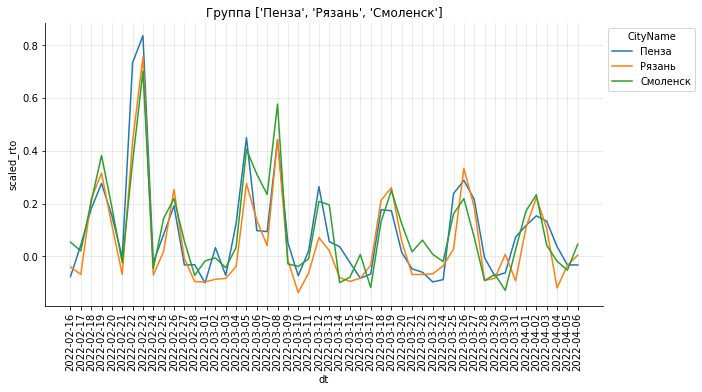

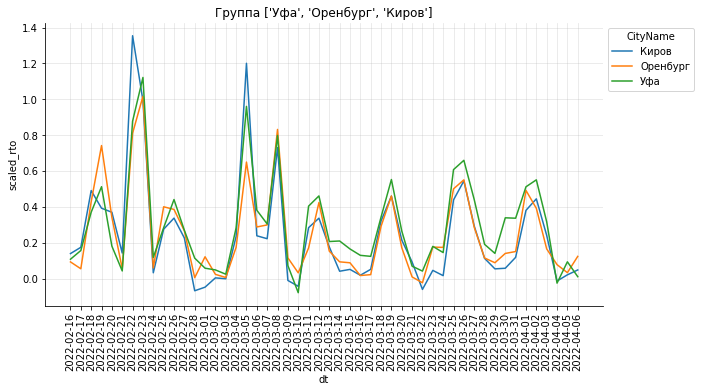

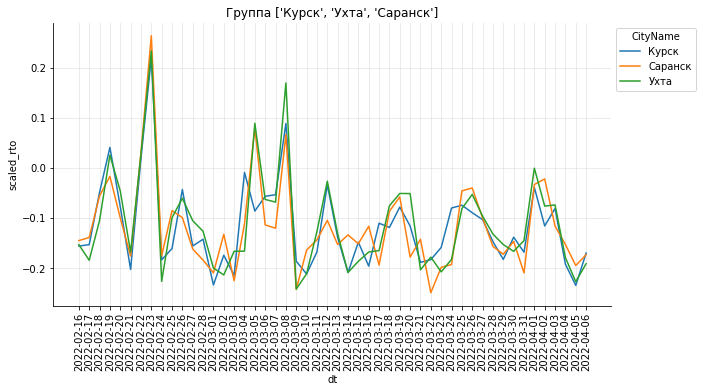

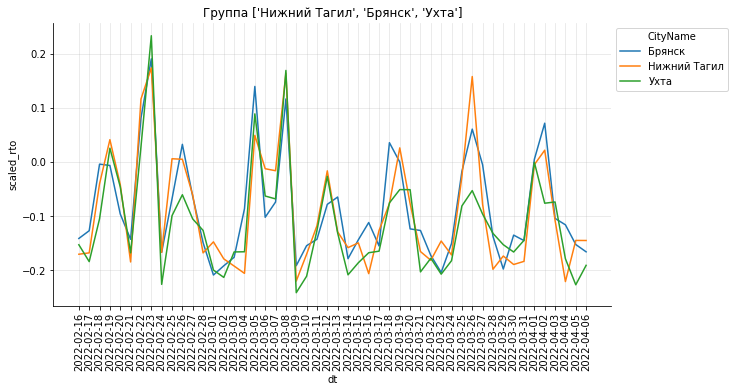

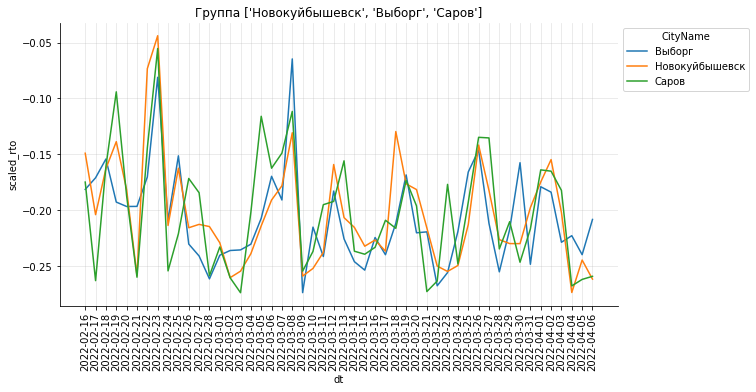

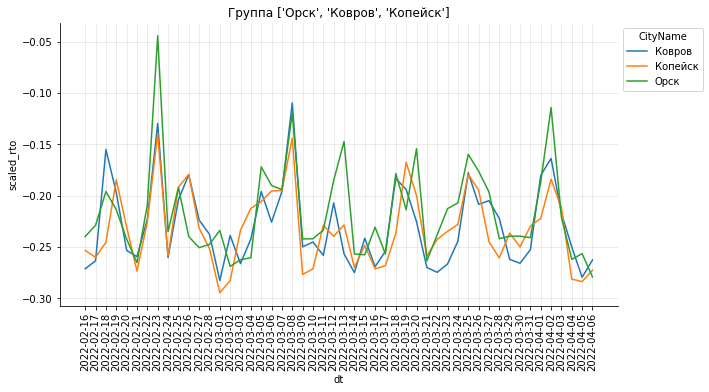

In [44]:
for i in test_towns:

    plot_time_series(
        df=knn_pre_exp_clean[knn_pre_exp_clean["CityName"].isin(result_ids[i])],
        metric_name="scaled_rto",
        grouped_column="CityName",
        time_series_name="dt",
        title=f"Группа {result_ids[i]}"
    )

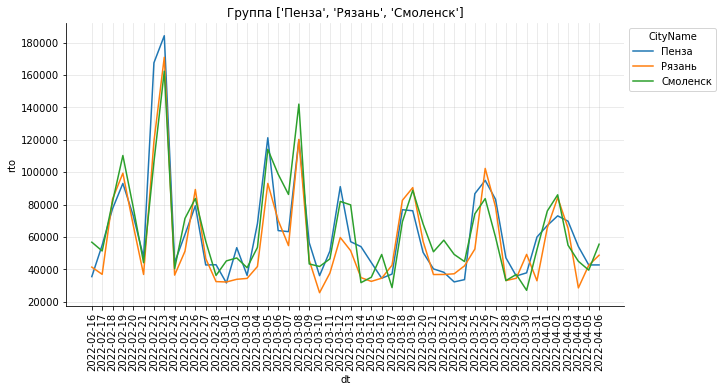

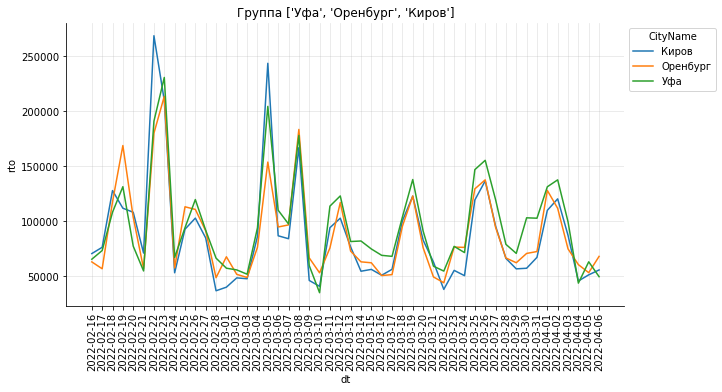

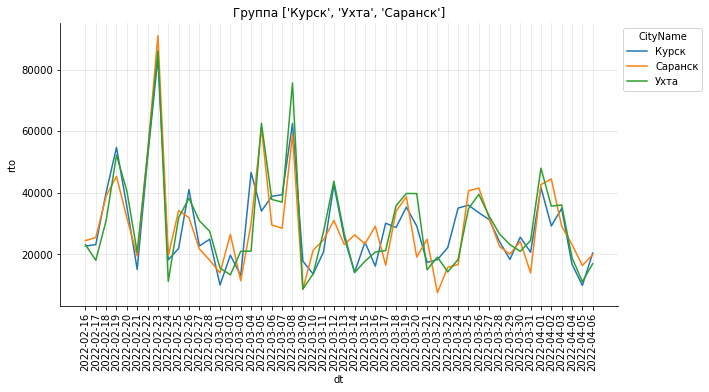

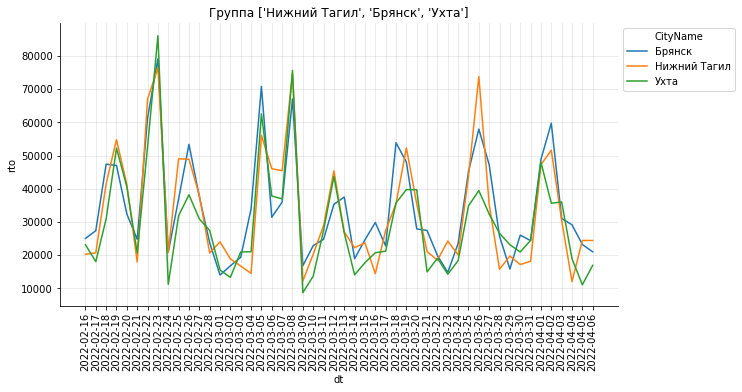

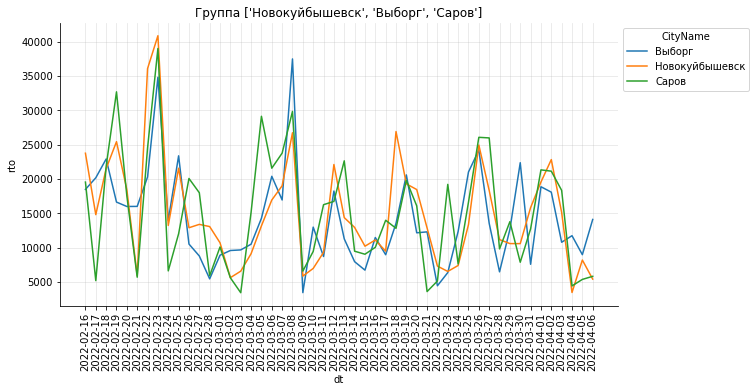

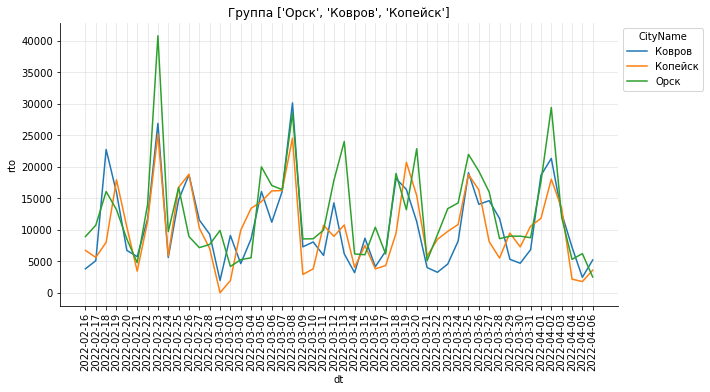

In [46]:
# абсолютные величины
for i in test_towns:

    plot_time_series(
        df=pre_exp[pre_exp["CityName"].isin(result_ids[i])],
        metric_name="rto",
        grouped_column="CityName",
        time_series_name="dt",
        title=f"Группа {result_ids[i]}"
    )